In [1]:
from models import pretrained
from data.uci_heart import UCIHeartModule
from data.cifar10 import CIFAR10DataModule
from data.camelyon import CamelyonModule
import torch
from torchsummary import summary
from surgeon_pytorch import Inspect, get_layers
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from random import sample, Random
from torchvision.models import resnet18
import pandas as pd

torch.set_grad_enabled(False);

In [2]:
class CustomBlock(torch.nn.Module):
    def __init__(self, original_block):
        super().__init__()
        self.original_block = original_block

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.original_block.conv1(x)
        out = self.original_block.bn1(out)
        out = self.original_block.relu(out)

        out = self.original_block.conv2(out)
        out = self.original_block.bn2(out)

        if self.original_block.downsample is not None:
            identity = self.original_block.downsample(x)

        out += identity
        return out

In [3]:
model = pretrained.camelyon_model().model
model.eval()
children = list(model.children())[:-2]
children[-1][-1] = CustomBlock(children[-1][-1])
m = torch.nn.Sequential(*children).cuda()

In [4]:
def get_activations(dl):
    z_ = []
    y_ = []
    for x, y in tqdm(dl):
        x = x.cuda()
        z = m(x)[..., 0, 0].cpu()
        y_.append(y)
        z_.append(z)

    return torch.cat(z_, dim=0), torch.cat(y_, dim=0)

In [5]:
dm = CamelyonModule(num_workers=4, shift=True, negative_labels=False, test_samples=1000, train_samples=50000, val_samples=10000)

z_train, y_train = get_activations(dm.train_dataloader())
z_val, y_val = get_activations(dm.val_dataloader())
z_ood, _ = get_activations(dm.test_dataloader())

dm = CamelyonModule(num_workers=4, shift=False, negative_labels=False, test_samples=1000)
z_iid, _ = get_activations(dm.test_dataloader())

  0%|                                                            | 0/98 [00:00<?, ?it/s]/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|█████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


In [8]:
model = pretrained.mlp_trained_on_uci_heart(seed=16).model
dm = UCIHeartModule(batch_size=1000, num_workers=4)
x, y_train = next(iter(dm.train_dataloader()))
z_train = model[:5](x)

In [6]:
feat_mask = (z_train.std(0) > 1e-7)
z_iid = z_iid[:, feat_mask]
z_train = z_train[:, feat_mask]
z_val = z_val[:, feat_mask]
z_ood = z_ood[:, feat_mask]

In [12]:
z_train.std(0).max()

tensor(1.5104)

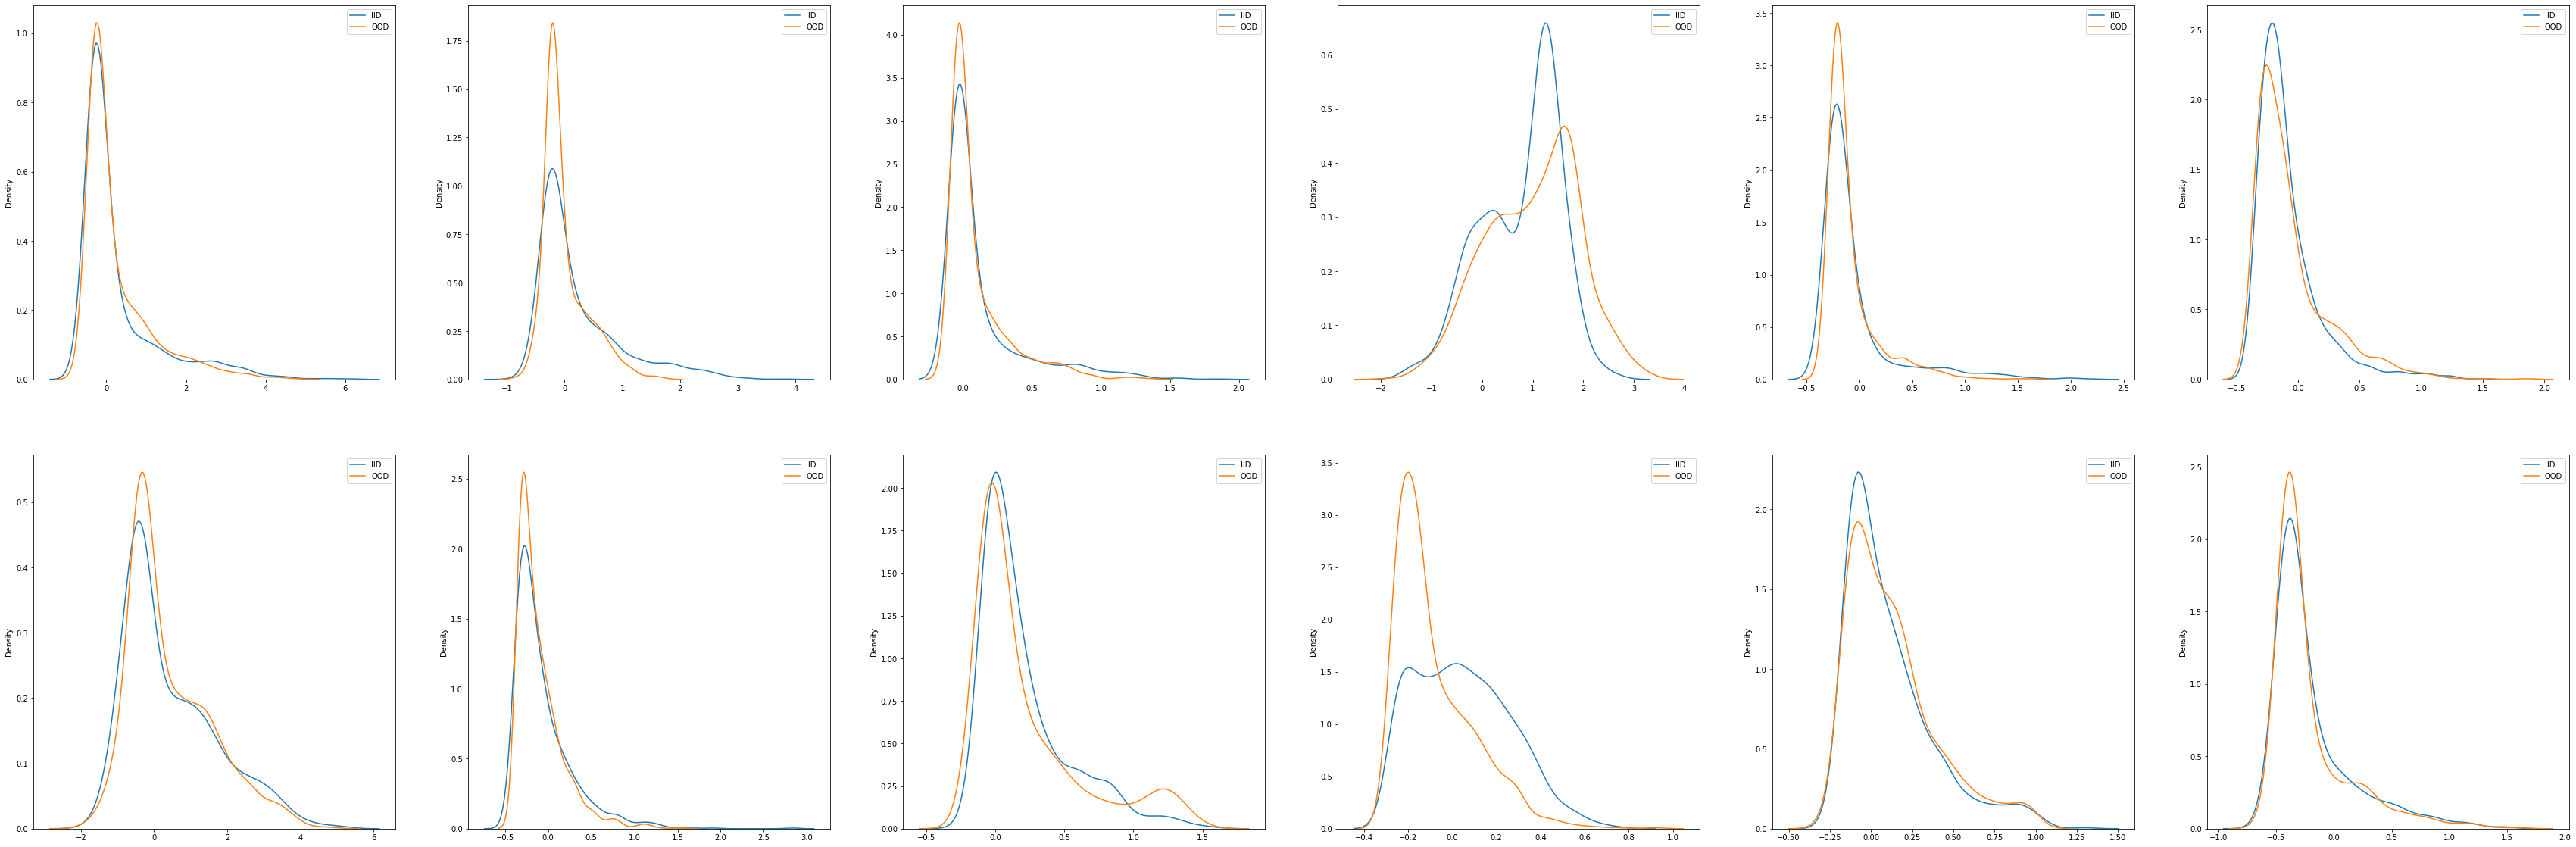

In [8]:
fig, ax = plt.subplots(2, 6, figsize=(60,20))
for i, a in zip(range(12), ax.ravel()):
    sns.kdeplot(z_iid[:, i].numpy(), label='IID', ax=a)
    sns.kdeplot(z_ood[:, i].numpy(), label='OOD', ax=a)
    a.legend()
plt.show()

In [13]:
def inverse_cov(z: torch.Tensor, n):
    """
    Covariance matrix of a data matrix
    :param n:
    :param z:
    :return:
    """
    # center data
    z = z - z.mean(dim=0)
    # covariance matrix
    return torch.inverse((z.T @ z) / n)


def cov(z: torch.Tensor):
    """
    Covariance matrix of a data matrix
    :param z:
    :return:
    """
    # center data
    z = z - z.mean(dim=0)
    # covariance matrix
    return (z.T @ z) / z.shape[0]


def fit_gaussian(z: torch.Tensor, n):
    mu = z.mean(dim=0)
    return mu, inverse_cov(z, n)


def gaussian_parameters(z, y):
    print(f'Fitting gaussians for {len(y.unique())} classes...')
    n = z.shape[0]
    means, covs = list(zip(*[(fit_gaussian(z[y == i], n)) for i in y.unique()]))
    m0, cov0 = fit_gaussian(z, n)
    return means, torch.stack(covs).sum(0), m0, cov0


def mahalanobis_distance(x, mu, inv_cov):
    return (x - mu).T @ inv_cov @ (x - mu)


def relative_mahalanobis_distance(z, means, inv_cov, mean_0, inv_cov_0):
    return min(mahalanobis_distance(z, m, inv_cov) for m in means) - mahalanobis_distance(z, mean_0, inv_cov_0)


params = gaussian_parameters(z_train, y_train)

Fitting gaussians for 2 classes...


In [10]:
x, _ = next(iter(dm.val_dataloader()))
z_val = model[:4](x)

x, _ = next(iter(dm.test_dataloader(specific_test_loader='iid')))
z_iid = model[:4](x)

x, _ = next(iter(dm.test_dataloader(specific_test_loader='ood')))
z_ood = model[:4](x)

In [14]:
n = torch.stack([relative_mahalanobis_distance(z_, *params) for z_ in tqdm(z_iid)]).numpy()
s = torch.stack([relative_mahalanobis_distance(z_, *params) for z_ in tqdm(z_ood)]).numpy()
v = torch.stack([relative_mahalanobis_distance(z_, *params) for z_ in tqdm(z_val)]).numpy()

100%|███████████████████████████████████████████| 10000/10000 [00:01<00:00, 5484.66it/s]


Text(0.5, 0, 'Penultimate Layer Relative Mahalanobis Scores')

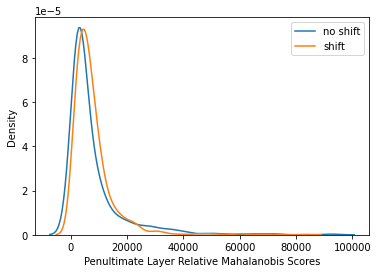

In [15]:
# sns.kdeplot(v, label='val')
sns.kdeplot(n, label='no shift')
sns.kdeplot(s, label='shift')
plt.legend()
plt.xlabel('Penultimate Layer Relative Mahalanobis Scores')

In [22]:
res = []
for seed in tqdm(range(100)):
    for test_samples in [10, 20, 50]:
        for shift in [True, False]:
            data = s if shift else n
            rnd = Random(seed)
            idx = rnd.sample(range(data.shape[0]), k=test_samples)
            pv = ks_2samp(v, data[idx]).pvalue
            res.append({'test_samples': test_samples, 'shift': shift, 'pvals': pv, 'seed': seed, 'algorithm': 'mahalanobis'})

100%|█████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


In [23]:


res = pd.DataFrame(res)

In [29]:
print(res.query('shift == False').pvals)

1     0.234202
3     0.505627
5     0.586658
7     0.462313
9     0.140145
11    0.143132
13    0.862242
15    0.477465
17    0.881091
19    0.388875
21    0.897634
23    0.087499
25    0.466143
27    0.420702
29    0.814919
31    0.264728
33    0.906217
35    0.672595
37    0.809452
39    0.413527
41    0.979473
43    0.711815
45    0.452346
47    0.801853
49    0.741434
51    0.362042
53    0.256698
55    0.700630
57    0.606502
59    0.652702
Name: pvals, dtype: float64


In [27]:
res.to_csv('../tables/camelyon/mahal.csv', index=False)

<AxesSubplot:xlabel='pvals', ylabel='Density'>

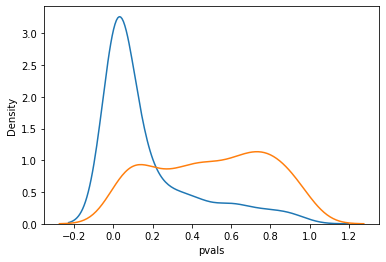

In [26]:
sns.kdeplot(res.query('shift == True').pvals)
sns.kdeplot(res.query('shift == False').pvals)